# Draft 1 - Figure 4

__Brainstormed Description:__  

_Maps Regional (IPCC) and Spatial (5x5deg) of a. obs. unc. spread, b. Model ICV spread, and c. their ratio. (methods for the spread values are introduced in Figure 3)._

So I will need to work with both the IPCC regional and 5x5 degree spatial data. This will be similar to figure 1.

### Load functions and packages

In [1]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask, gridspec,
    mpl, copy
    )

from functions import to_png

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import regionmask

import cartopy.crs as ccrs
import matplotlib.patheffects as pe

from functions import sp_map

In [3]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap

In [4]:
def compute_tte(obs_trends,pic_trends):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    
    _tte_bool = obs_trends > pic_trends
    _tte      = 1960 + _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte!=1960+obs_trends.duration.max(),np.nan) # Mask the unemerged regions
    _tte      = _tte.drop(['percentile'])
    
    return _tte

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

In [5]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

Take percentiles from PI-Control Runs of models

In [6]:
cesm1_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_spatial_trends_filepath = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

In [7]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [8]:
cesm1_pic_spatial_trends_all   = xr.open_dataarray(*cesm1_spatial_trends_filepath)

mpi_pic_spatial_trends_all     = xr.open_dataarray(*mpi_spatial_trends_filepath)

canesm2_pic_spatial_trends_all = xr.open_dataarray(*canesm2_spatial_trends_filepath)

esm2m_pic_spatial_trends_all   = xr.open_dataarray(*esm2m_spatial_trends_filepath)

In [9]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(*cesm1_regional_trends_filepath)

mpi_pic_regional_trends_all     = xr.open_dataarray(*mpi_regional_trends_filepath)

canesm2_pic_regional_trends_all = xr.open_dataarray(*canesm2_regional_trends_filepath)

esm2m_pic_regional_trends_all   = xr.open_dataarray(*esm2m_regional_trends_filepath)

#### Observations

And the OBS-LE is effectively used as a model so I just want the percentiles.

In [10]:
obs_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/'
hadcrut5_dir    = 'HadCRUT5/'
obsle_dir       = 'mckinnon_OLENS/'

In [11]:
gistemp_tas_var = 'tempAnom'
hadcrut5_tas_var = 'tas'
obsle_tas_var    = 'tas'

In [12]:
gistemp_5x5_spatial_trends_filepath  = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,hadcrut5_dir))
obsle_spatial_trends_filepath        = glob.glob('%s/%s/*.5x5*.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [13]:
gistemp_5x5_regional_trends_filepath  = glob.glob('%s/%s/*trends.196001-202012*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_regional_trends_filepath     = glob.glob('%s/%s/*trends.196001-202012*.nc' % (obs_tseries_dir,hadcrut5_dir))
obsle_regional_trends_filepath        = glob.glob('%s/%s/*region*.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

Load the trend data

In [14]:
gistemp_5x5_spatial_trends_all  = xr.open_mfdataset(gistemp_5x5_spatial_trends_filepath).drop('startyear')['tas'].chunk({'record': -1})
hadcrut5_spatial_trends_all     = xr.open_mfdataset(hadcrut5_spatial_trends_filepath).drop('startyear').rename({'longitude':'lon','latitude':'lat','realization':'record'})['tas'].chunk({'record': -1})
gistemp_5x5_spatial_trends_all['record'] = gistemp_5x5_spatial_trends_all['record'] - 2 # Shift back to 1
obsle_spatial_trends_all        = xr.open_dataarray(*obsle_spatial_trends_filepath)

In [15]:
gistemp_5x5_regional_trends_all  = xr.open_dataarray(*gistemp_5x5_regional_trends_filepath).sel(startyear=1960).drop('startyear')
hadcrut5_regional_trends_all     = xr.open_dataarray(*hadcrut5_regional_trends_filepath).sel(startyear=1960).drop('startyear').rename({'realization':'record'})
obsle_regional_trends_all        = xr.open_dataarray(*obsle_regional_trends_filepath)

record and realization

### Compute TTE generally

In [16]:
obs_spatial_trend_dict  = {'GISTEMP_5x5':gistemp_5x5_spatial_trends_all,
                           'HadCRUT':hadcrut5_spatial_trends_all}
obs_regional_trend_dict = {'GISTEMP_5x5':gistemp_5x5_regional_trends_all,
                           'HadCRUT':hadcrut5_regional_trends_all}
obs_trend_dict          = {'spatial':obs_spatial_trend_dict,
                           'regional':obs_regional_trend_dict}

model_spatial_trend_dict = {'CESM1':cesm1_pic_spatial_trends_all,
                            'MPI':mpi_pic_spatial_trends_all,
                            'CanESM2':canesm2_pic_spatial_trends_all,
                            'ESM2M':esm2m_pic_spatial_trends_all,
                            'OBS-LE':obsle_spatial_trends_all,
                           }

model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                             'MPI':mpi_pic_regional_trends_all,
                             'CanESM2':canesm2_pic_regional_trends_all,
                             'ESM2M':esm2m_pic_regional_trends_all,
                             'OBS-LE':obsle_regional_trends_all,
                            }
                                         
model_trend_dict          = {'spatial':model_spatial_trend_dict,
                             'regional':model_regional_trend_dict}

Compute the TTE for each ensemble member separately.

In [17]:
%%time 

spatial_box = []
regional_box = []

# Iterate over regional vs. spatial
for _location_type in list(obs_trend_dict.keys()):
    
    print(_location_type)
    _box = spatial_box if (_location_type == 'spatial') else regional_box
    location_box = []
    
    _allobs_trends = obs_trend_dict[_location_type]
    _allmodel_trends = model_trend_dict[_location_type]
    
    for _obs_product in list(_allobs_trends.keys()):
        print(_obs_product)
        obs_box = []
        
        _obs_trends = _allobs_trends[_obs_product]
        
        for _model_product in list(_allmodel_trends.keys()):
            print(_model_product)
            _model_trends = _allmodel_trends[_model_product]
            
            # Compute ToE of the median trend (more consistent with using the 50%ile trend for mean)
            _mean_toe = compute_tte(obs_trends=_obs_trends.median(dim='record'),
                                    pic_trends=_model_trends.sel(percentile=97.5))

            # Compute ToE for each ensemble member and take the 95th percentile
            _strict_toe = compute_tte(obs_trends=_obs_trends,
                                      pic_trends=_model_trends.sel(percentile=97.5))

            # Switch nans to infs in order to compute the strict ToE correctly. Then switch infs back to nans in order to mask correctly.
            _strict_toe = _strict_toe.where(~np.isnan(_strict_toe),np.inf).quantile(q=0.95,dim='record',interpolation='nearest')
            _strict_toe = _strict_toe.where(~np.isinf(_strict_toe),np.nan)
            
            # Compute the delay and conditional delay mask:
            _delay_toe = _strict_toe - _mean_toe # Compute the delay
            _delay_undef_region = np.bitwise_and(np.isnan(_strict_toe), ~np.isnan(_mean_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
            _delay_toe = xr.where(_delay_undef_region,2020 - _mean_toe,_delay_toe) # Apply the conditional mask

            _toes = xr.concat([_mean_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
                               _strict_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
                               _delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
                               _delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
                              ],
                              dim='metric',
                             )            
                              
            obs_box.append(_toes.assign_coords({'model':_model_product},).expand_dims(['model'],axis=[-1]))
                        
        location_box.append(xr.concat(obs_box,dim='model').assign_coords({'obs':_obs_product},).expand_dims(['obs'],axis=[-1]))
    _box.append(xr.concat(location_box,dim='obs').compute())
    
spatial_masked_da = spatial_box[0]

spatial
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
OBS-LE
HadCRUT
CESM1
MPI
CanESM2
ESM2M
OBS-LE


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


regional
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
OBS-LE
HadCRUT
CESM1
MPI
CanESM2
ESM2M
OBS-LE
CPU times: user 7.38 s, sys: 1.22 s, total: 8.6 s
Wall time: 9.03 s


### Plot with IPCC Regions

Need to convert the IPCC Region Indexing to lat-lon coordinates in order to plot spatially.

In [18]:
%%time

# User set-up
data  = regional_box[0]

mean_data   = data.sel(metric='mean')
strict_data = data.sel(metric='strict')
delay_data  = data.sel(metric='delay')
delay_mask  = data.sel(metric='delay_mask')

# ipcc_ar6_regions_land   = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_all    = regionmask.defined_regions.ar6.all

# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
unc_mask = ipcc_ar6_regions_all.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

# CESM1-GISTEMP 5x5
_mean_mask   = unc_mask.copy()
_strict_mask = unc_mask.copy()
_delay_data_mask  = unc_mask.copy()
_delay_mask_mask  = unc_mask.copy()

del unc_mask

offset = -1000 # Need an offset or it may confuse regions with the delays (delays are on [0,40] similar to the region indices)
for i in ipcc_ar6_regions_all.numbers:
    
    _mean_mask   = xr.where(_mean_mask==i,mean_data.sel(RegionIndex=i)+offset,_mean_mask)
    _strict_mask = xr.where(_strict_mask==i,strict_data.sel(RegionIndex=i)+offset,_strict_mask)
    _delay_data_mask  = xr.where(_delay_data_mask==i,delay_data.sel(RegionIndex=i)+offset,_delay_data_mask)
    _delay_mask_mask  = xr.where(_delay_mask_mask==i,delay_mask.sel(RegionIndex=i)+offset,_delay_mask_mask)

regional_masked_da = xr.concat([_mean_mask,_strict_mask,_delay_data_mask,_delay_mask_mask],dim='metric')-offset

CPU times: user 2.27 s, sys: 89.6 ms, total: 2.36 s
Wall time: 2.66 s


#### Plot the spread over models vs. over the observational products.

Compute the spread values:

- The obs. spread is the average separation between 1 model with both obs. products
- The model spread is the spread for all models with one observational product, averaged for the two obs. products

If I want to remove the effect of the Mckinnon OBS-LE, I can just do this:  

_regional_masked_da.isel(model=slice(None,4))_  

_spatial_masked_da.isel(model=slice(None,4))_

In [19]:
regional_toe_mean   = regional_masked_da.sel(metric='mean')
regional_toe_strict = regional_masked_da.sel(metric='strict')

# skipna = False when operating over the 'obs' dimension because it only has a single value!
region_mean_obs_spread = (regional_toe_mean.max(dim='obs',skipna=False) - regional_toe_mean.min(dim='obs',skipna=False)).mean(dim='model') # Average spread between GISTEMP and HadCRUT
region_mean_mod_spread = (regional_toe_mean.max(dim='model') - regional_toe_mean.min(dim='model')).mean(dim='obs',skipna=True)

region_strict_obs_spread = (regional_toe_strict.max(dim='obs',skipna=False) - regional_toe_strict.min(dim='obs',skipna=False)).mean(dim='model')
region_strict_mod_spread = (regional_toe_strict.max(dim='model') - regional_toe_strict.min(dim='model')).mean(dim='obs',skipna=True)

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [20]:
spatial_toe_mean = spatial_masked_da.sel(metric='mean')
spatial_toe_strict = spatial_masked_da.sel(metric='strict')

spatial_mean_obs_spread = (spatial_toe_mean.max(dim='obs',skipna=False) - spatial_toe_mean.min(dim='obs',skipna=False)).mean(dim='model') # Average spread between GISTEMP and HadCRUT
spatial_mean_mod_spread = (spatial_toe_mean.max(dim='model') - spatial_toe_mean.min(dim='model')).mean(dim='obs',skipna=True)

spatial_strict_obs_spread = (spatial_toe_strict.max(dim='obs',skipna=False) - spatial_toe_strict.min(dim='obs',skipna=False)).mean(dim='model')
spatial_strict_mod_spread = (spatial_toe_strict.max(dim='model') - spatial_toe_strict.min(dim='model')).mean(dim='obs',skipna=True)

In [21]:
# Function for the regional figures.
def plot_regional_spread(obs_spread,model_spread,title=True):

    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(21,6))
    axs = axs.flat

    cax1 = plt.axes([0.18, 0.22, 0.40, 0.03])
    cax2 = plt.axes([0.675, 0.22, 0.20, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    Toe_cmap = ListedColormap(sns.color_palette('viridis',n_colors=256))    
    
    delay_cmap = ListedColormap(sns.color_palette('vlag',n_colors=256))
    delay_cmap.set_over('darkred')
    delay_cmap.set_under('darkblue')
    
    spread_levels = np.linspace(0,20,5) # This should exclude zeros
    delay_levels  = np.linspace(-0.8,0.8,9)
    spread_ratio  = np.log10(obs_spread/model_spread)
    
    masks  = [obs_spread,model_spread,spread_ratio]
    titles = ['Obs Spread','Model Spread','Uncertainty Ratio (obs / model)']
    levels = [spread_levels,spread_levels,delay_levels] 
    cmaps = [Toe_cmap,Toe_cmap,delay_cmap]
    extend = ['max','max','both']

    plt.subplots_adjust(wspace=0.05)

    ims = [] 
    for _ax,_mask,_label,_levels,_cmap,_extend in zip(axs,masks,titles,levels,cmaps,extend):

        im = _ax.contourf(_mask.lon,_mask.lat,_mask, 60,
                          transform=ccrs.PlateCarree(),
                          levels=_levels,
                          cmap=_cmap,
                          extend=_extend,
                         )
        
        _ = _ax.contourf(_mask.lon,_mask.lat,np.isnan(_mask),
                         transform=ccrs.PlateCarree(),
                         levels=[0,0.5,1.5],
                         extend='max',
                         colors=['none','gray'],
                         hatches=[None,'\\\\',],
                        )    

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)

    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=spread_levels,
                         cax=cax1,#label='Years',
                        )
    cbar1.set_label(label='Years',size=15,weight=None)

    cbar2 = fig.colorbar(ims[2],orientation='horizontal',
                         ticks=delay_levels,
                         cax=cax2,
                        )
    cbar2.set_label(label='$log_{10}(\delta_{obs} / \delta_{model}$)',size=15,weight=None)

    cbar1.ax.tick_params(labelsize=12) 
    cbar2.ax.tick_params(labelsize=12)
    
    if title:
        fig.suptitle('Method Spread',fontsize=20,y=0.87)
    
    return fig

It works.

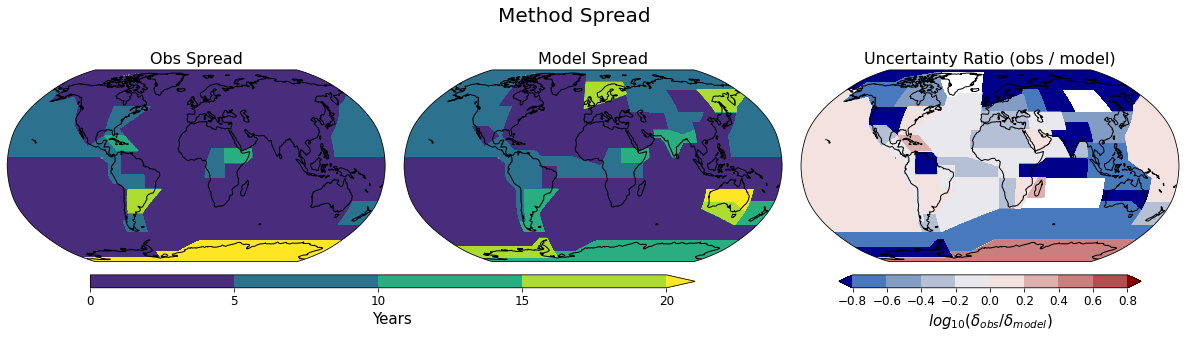

In [22]:
out_fig = plot_regional_spread(region_mean_obs_spread,region_mean_mod_spread,)

to_png(file=out_fig,filename='draft2_meanToE_spread_regionalmap',dpi=300,ext='pdf',bbox_inches='tight')

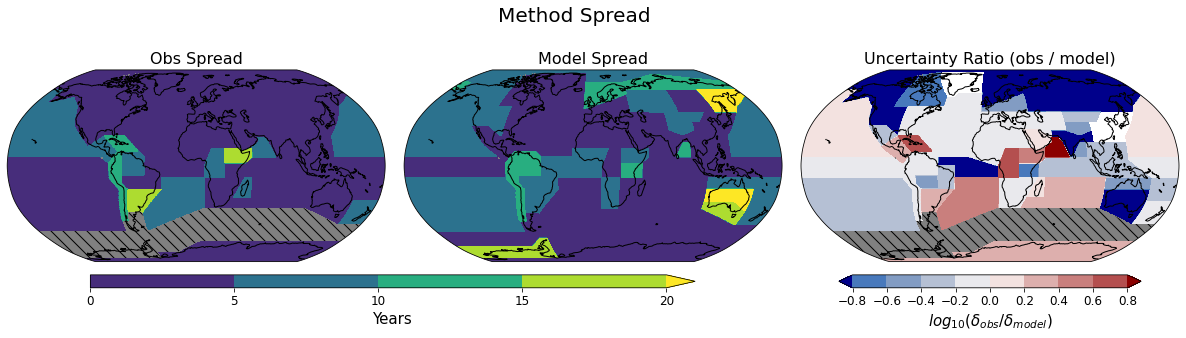

In [23]:
out_fig = plot_regional_spread(region_strict_obs_spread,region_strict_mod_spread,)

to_png(file=out_fig,filename='draft2_strictToE_spread_regionalmap',dpi=300,ext='pdf',bbox_inches='tight')

__This is not as useful as the spatial plots. The ratio panel is especially confusing, it mostly shows that observational uncertainty is relatively low over N.H. continents and Australia.__

Also the masking seems to be having an issue. Or zero values are being plotted wrong...  
^This is mostly fixed. I am calculating the model spread even if one observational product has no values, hence why there is zero spread for the strict emergence of E. Antarctica (only 2 of 8 values are not nan, but they are equal).

#### Spatial Data

In [24]:
def plot_spatial_spread(obs_spread,model_spread,title=True,bool_pcolor=[True,True,False]):

    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(21,6))
    axs = axs.flat

    cax1 = plt.axes([0.175, 0.22, 0.40, 0.03])
    cax2 = plt.axes([0.675, 0.22, 0.20, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    Toe_cmap = ListedColormap(sns.color_palette('viridis',n_colors=256))
    # ToE_cmap = copy.copy(mpl.cm.autumn_r)
    # ToE_cmap = copy.copy(mpl.cm.YlOrBr) # 
    
    delay_cmap = ListedColormap(sns.color_palette('vlag',n_colors=256))
    delay_cmap.set_over('darkred')
    delay_cmap.set_under('darkblue')
    
    spread_levels = np.linspace(0,20,5)
    delay_levels  = np.linspace(-0.8,0.8,9)
    spread_ratio  = np.log10(obs_spread/model_spread)

    masks  = [obs_spread,model_spread,spread_ratio]
    titles = ['Obs Spread','Model Spread','Spread Ratio (obs. / model)']
    levels = [spread_levels,spread_levels,delay_levels] 
    cmaps = [ToE_cmap,ToE_cmap,delay_cmap]
    extend = ['max','max','both']

    plt.subplots_adjust(wspace=0.05)
    
    ims = [] 
    for _ax,_mask,_label,_levels,_cmap,_pcolor,_extend in zip(axs,masks,titles,levels,cmaps,bool_pcolor,extend):
        if _pcolor:
            _norm = BoundaryNorm(_levels, ncolors=_cmap.N, clip=False,extend=_extend)
            im = _ax.pcolormesh(_mask.lon,_mask.lat,_mask,
                               transform=ccrs.PlateCarree(),
                               cmap=_cmap,
                               norm=_norm, 
                               )
        else:
            im = _ax.contourf(_mask.lon,_mask.lat,_mask,
                              transform=ccrs.PlateCarree(),
                              cmap=_cmap,
                              levels=_levels,
                              extend=_extend,
                             )

        _ = _ax.contourf(_mask.lon,_mask.lat,np.isnan(_mask),
                         transform=ccrs.PlateCarree(),
                         levels=[0,0.5,1.5],
                         extend='max',
                         colors=['none','gray'],
                         hatches=[None,'\\\\',],
                        )     

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)
        
    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=np.linspace(0,20,5),
                         cax=cax1,#label='Years',
                         extend='max',
                        )
    cbar1.set_label(label='Years',size=15,weight=None)

    cbar2 = fig.colorbar(ims[2],orientation='horizontal',
                         ticks=delay_levels,
                         cax=cax2,
                         extend='both',
                        )
    cbar2.set_label(label='$log_{10}(\delta_{obs} / \delta_{model}$)',size=15,weight=None)

    cbar1.ax.tick_params(labelsize=12) 
    cbar2.ax.tick_params(labelsize=12)

    if title:
        fig.suptitle('Method Spread',fontsize=20,y=0.88)    

    return fig

The white splotches are gridcells where the ratio actually becomes pretty even. I could do some more smoothing, but I'm not sure that's the right approach.

__Observational Uncertainty Dominates in the Tropics, Model Uncertainty dominates in the northern hemisphere. The Southern Ocean hasn't emerged so we don't assess spread there.__

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


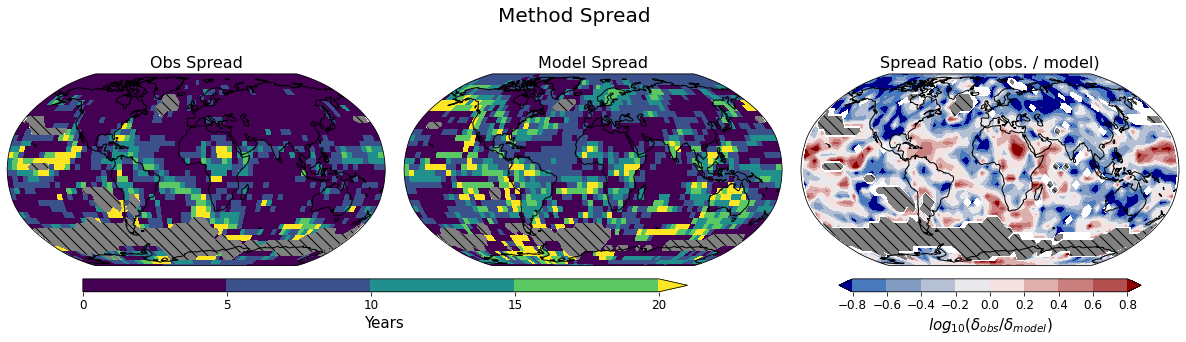

In [25]:
out_fig = plot_spatial_spread(spatial_mean_obs_spread,spatial_mean_mod_spread,bool_pcolor=[True,True,False])

to_png(file=out_fig,filename='draft2_meanToE_spread_spatialmap',dpi=300,ext='pdf',bbox_inches='tight')

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


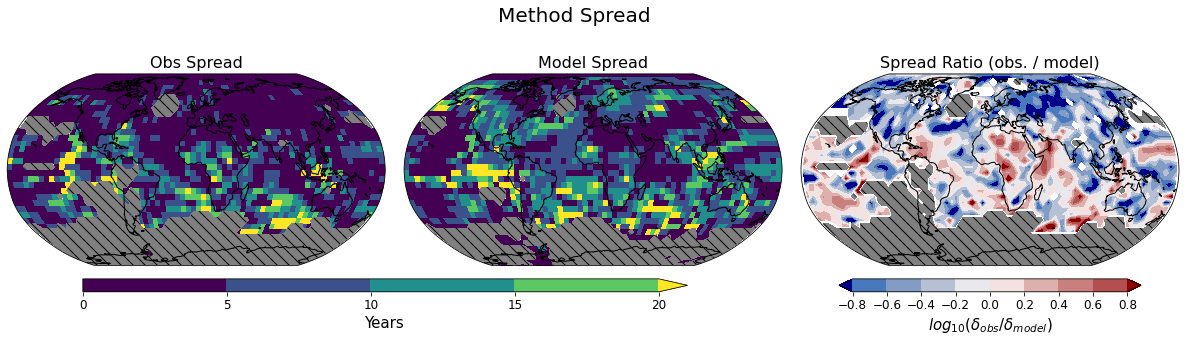

In [26]:
out_fig = plot_spatial_spread(spatial_strict_obs_spread,spatial_strict_mod_spread,bool_pcolor=[True,True,False])

to_png(file=out_fig,filename='draft2_strictToE_spread_spatialmap',dpi=300,ext='pdf',bbox_inches='tight')